In [1]:
import os
import glob
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score, f1_score
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.metrics import precision_score, recall_score, f1_score
from transformers import get_cosine_schedule_with_warmup
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

In [5]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

def compute_metrics(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    precision = precision_score(labels_flat, pred_flat, average='weighted')
    recall = recall_score(labels_flat, pred_flat, average='weighted')
    f1 = f1_score(labels, pred_flat, average='weighted', zero_division=1)
    accuracy = np.sum(pred_flat == labels_flat) / len(labels_flat)

    return {
        "accuracy": accuracy,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

model_choice = input("Choose your model (bert/gpt2): ")

if model_choice.lower() not in ['bert', 'gpt2']:
    raise ValueError("Invalid model choice. Choose 'bert' or 'gpt2'.")


Choose your model (bert/gpt2):  bert


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
filepath = '/datasets/fig_speech/' # update this path to your files
extension = 'txt'

files = glob.glob(filepath + '*.' + extension)

df = pd.DataFrame()

for file in files:
    with open(file, 'r') as f:
        content = f.read().splitlines()
        temp_df = pd.DataFrame(content, columns=['sentence'])
        filename = os.path.basename(file)
        label = os.path.splitext(filename)[0]
        temp_df['label'] = label
        df = pd.concat([df, temp_df])

labels = df.label.unique()
label_dict = {label: i for i, label in enumerate(labels)}
df['label'] = df.label.replace(label_dict)

df = df.sample(frac=1).reset_index(drop=True)
train_sentences, val_sentences, train_labels, val_labels = train_test_split(df.sentence, df.label, test_size=0.3)

In [7]:
label_dict

{'Alliteration': 0,
 'Hyperbole': 1,
 'Metaphor': 2,
 'Onomatopoeia': 3,
 'Paradox': 4,
 'Personification': 5,
 'Pun': 6,
 'Simile': 7}

In [8]:
df.head()

,sentence,label
0,A light in a sea of darkness.,2
1,"The gentle raindrops tapped on the windowpane,...",0
2,as soft as a daffodil's petals,7
3,As neat as ninepins,7
4,Anal sex does not make one's day it makes one'...,6


sentence    0
label       0
dtype: int64
                                            sentence  label
0                      A light in a sea of darkness.      2
1  The gentle raindrops tapped on the windowpane,...      0
2                     as soft as a daffodil's petals      7
3                                As neat as ninepins      7
4  Anal sex does not make one's day it makes one'...      6
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5496 entries, 0 to 5495
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  5496 non-null   object
 1   label     5496 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 86.0+ KB
None
             label
count  5496.000000
mean      4.069505
std       2.336771
min       0.000000
25%       2.000000
50%       5.000000
75%       6.000000
max       7.000000
7    1026
6    1001
5     736
2     674
1     602
4     593
0     472
3     392
Name: label, dtype: int64


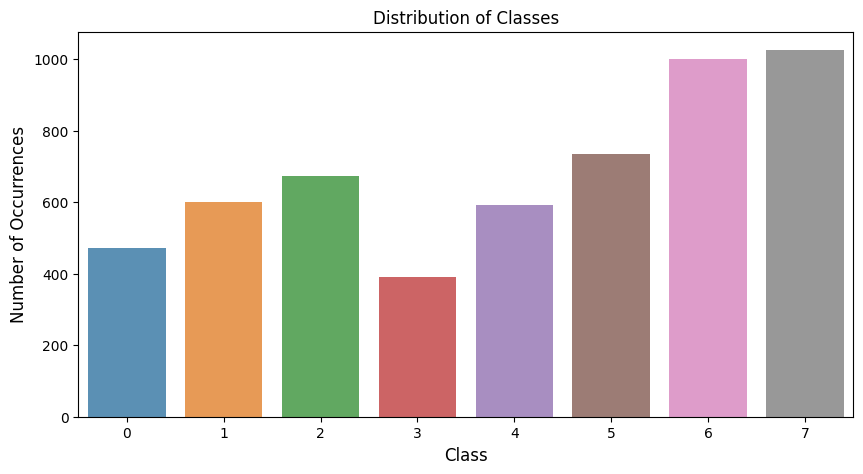

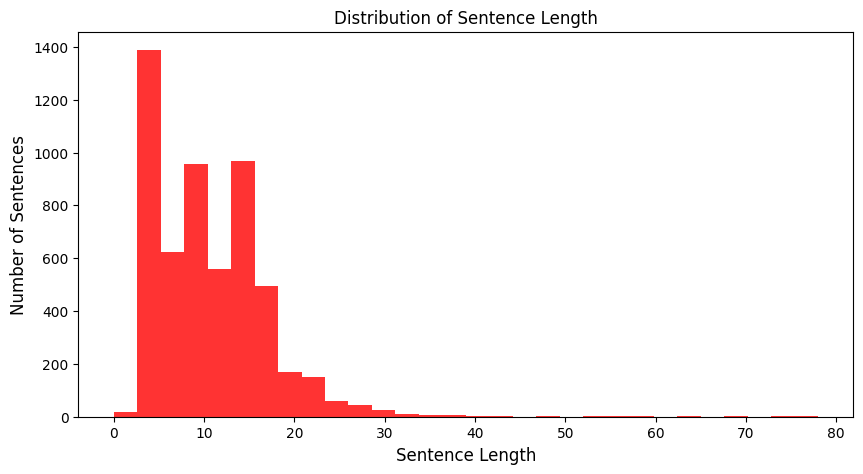

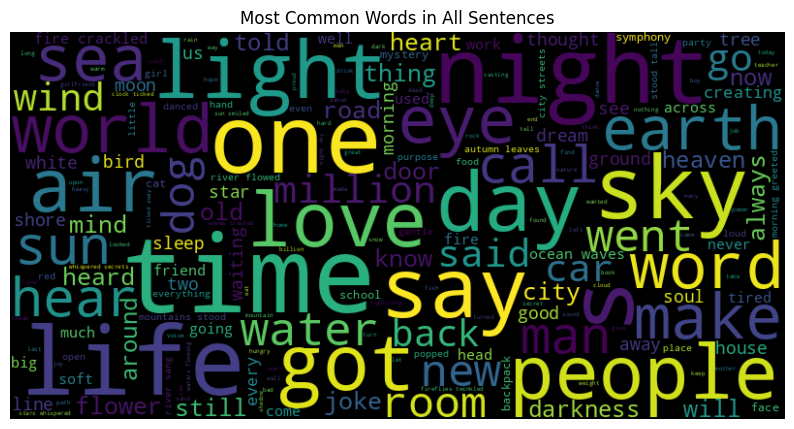

In [9]:
# Make a copy of the DataFrame
df_copy = df.copy()

# Check for null values
print(df_copy.isnull().sum())

# Print the first few rows of the DataFrame
print(df_copy.head())

# Print information about the DataFrame
print(df_copy.info())

# Describe the DataFrame (gives statistical information)
print(df_copy.describe())

# Count the number of each class
class_counts = df_copy['label'].value_counts()
print(class_counts)

# Plot the distribution of classes
plt.figure(figsize=(10,5))
sns.barplot(x=class_counts.index, y=class_counts.values, alpha=0.8)
plt.title('Distribution of Classes')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Class', fontsize=12)
plt.show()

# Analyze sentence length
df_copy['sentence_len'] = df_copy['sentence'].apply(lambda x: len(x.split()))
sentence_lengths = list(df_copy['sentence_len'])
plt.figure(figsize=(10,5))
plt.hist(sentence_lengths, bins=30, alpha=0.8, color='r')
plt.title('Distribution of Sentence Length')
plt.ylabel('Number of Sentences', fontsize=12)
plt.xlabel('Sentence Length', fontsize=12)
plt.show()

# Analyze most common words with Wordcloud
# Combine all sentences
all_words = ' '.join(df_copy['sentence'].values)
# Generate wordcloud
wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Most Common Words in All Sentences')
plt.show()


In [10]:
if model_choice.lower() == 'bert':
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(labels))
else:
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    model = GPT2ForSequenceClassification.from_pretrained("gpt2-large", num_labels=len(labels))
    tokenizer.pad_token = tokenizer.eos_token

train_encodings = tokenizer.batch_encode_plus(train_sentences.tolist(), truncation=True, padding=True, max_length=64)
val_encodings = tokenizer.batch_encode_plus(val_sentences.tolist(), truncation=True, padding=True, max_length=64)

train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']), torch.tensor(train_encodings['attention_mask']), torch.tensor(train_labels.tolist()))
val_dataset = TensorDataset(torch.tensor(val_encodings['input_ids']), torch.tensor(val_encodings['attention_mask']), torch.tensor(val_labels.tolist()))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [11]:
batch_size = 32

train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
validation_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)

model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 10
total_steps = len(train_dataloader) * epochs
warmup_steps = int(total_steps * 0.1)  # Set the warmup steps to 10% of total steps
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [12]:
from tqdm import tqdm

for epoch_i in range(0, epochs):
    
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    total_loss = 0
    model.train()

    # Here, we add a progress bar
    for step, batch in enumerate(tqdm(train_dataloader, desc="Iteration")):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        model.zero_grad()        
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)            
    
    print("Average training loss: {0:.2f}".format(avg_train_loss))

    print("Running Validation...")

    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Initialize counters for metrics at the start of each epoch
    metrics = {"accuracy": 0, "f1": 0, "precision": 0, "recall": 0}
    num_batches = 0

    # Add a progress bar for the validation loop as well
    for batch in tqdm(validation_dataloader, desc="Validating"):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
      
        with torch.no_grad():        
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        batch_metrics = compute_metrics(logits, label_ids)

        # Accumulate metrics over batches
        for key in batch_metrics.keys():
            metrics[key] += batch_metrics[key]
        
        num_batches += 1

    for key in metrics.keys():
        metrics[key] /= num_batches
        print(f"Validation {key.capitalize()}: {metrics[key]:.2f}")

# Save the model
if model_choice.lower() == 'bert':
    model_name = 'my_model_bert_base'
elif model_choice.lower() == 'gpt2':
    model_name = 'my_model_gpt2'
model.save_pretrained(model_name)


======== Epoch 1 / 10 ========


Iteration: 100%|██████████| 121/121 [00:35<00:00,  3.44it/s]


Average training loss: 1.73
Running Validation...


Validating: 100%|██████████| 52/52 [00:05<00:00,  9.14it/s]


Validation Accuracy: 0.68
Validation F1: 0.63
Validation Precision: 0.66
Validation Recall: 0.68
======== Epoch 2 / 10 ========


Iteration: 100%|██████████| 121/121 [00:34<00:00,  3.47it/s]


Average training loss: 0.80
Running Validation...


Validating: 100%|██████████| 52/52 [00:05<00:00,  9.16it/s]


Validation Accuracy: 0.83
Validation F1: 0.82
Validation Precision: 0.86
Validation Recall: 0.83
======== Epoch 3 / 10 ========


Iteration: 100%|██████████| 121/121 [00:34<00:00,  3.46it/s]


Average training loss: 0.40
Running Validation...


Validating: 100%|██████████| 52/52 [00:05<00:00,  9.02it/s]


Validation Accuracy: 0.85
Validation F1: 0.85
Validation Precision: 0.88
Validation Recall: 0.85
======== Epoch 4 / 10 ========


Iteration: 100%|██████████| 121/121 [00:35<00:00,  3.39it/s]


Average training loss: 0.23
Running Validation...


Validating: 100%|██████████| 52/52 [00:05<00:00,  8.92it/s]


Validation Accuracy: 0.86
Validation F1: 0.87
Validation Precision: 0.90
Validation Recall: 0.86
======== Epoch 5 / 10 ========


Iteration: 100%|██████████| 121/121 [00:35<00:00,  3.39it/s]


Average training loss: 0.16
Running Validation...


Validating: 100%|██████████| 52/52 [00:05<00:00,  8.93it/s]


Validation Accuracy: 0.87
Validation F1: 0.87
Validation Precision: 0.89
Validation Recall: 0.87
======== Epoch 6 / 10 ========


Iteration: 100%|██████████| 121/121 [00:35<00:00,  3.37it/s]


Average training loss: 0.11
Running Validation...


Validating: 100%|██████████| 52/52 [00:05<00:00,  8.99it/s]


Validation Accuracy: 0.87
Validation F1: 0.87
Validation Precision: 0.89
Validation Recall: 0.87
======== Epoch 7 / 10 ========


Iteration: 100%|██████████| 121/121 [00:35<00:00,  3.37it/s]


Average training loss: 0.09
Running Validation...


Validating: 100%|██████████| 52/52 [00:05<00:00,  8.91it/s]


Validation Accuracy: 0.86
Validation F1: 0.87
Validation Precision: 0.90
Validation Recall: 0.86
======== Epoch 8 / 10 ========


Iteration: 100%|██████████| 121/121 [00:35<00:00,  3.37it/s]


Average training loss: 0.09
Running Validation...


Validating: 100%|██████████| 52/52 [00:05<00:00,  8.91it/s]


Validation Accuracy: 0.86
Validation F1: 0.86
Validation Precision: 0.89
Validation Recall: 0.86
======== Epoch 9 / 10 ========


Iteration: 100%|██████████| 121/121 [00:35<00:00,  3.38it/s]


Average training loss: 0.08
Running Validation...


Validating: 100%|██████████| 52/52 [00:05<00:00,  8.97it/s]


Validation Accuracy: 0.87
Validation F1: 0.87
Validation Precision: 0.90
Validation Recall: 0.87
======== Epoch 10 / 10 ========


Iteration: 100%|██████████| 121/121 [00:35<00:00,  3.36it/s]


Average training loss: 0.07
Running Validation...


Validating: 100%|██████████| 52/52 [00:05<00:00,  8.93it/s]


Validation Accuracy: 0.87
Validation F1: 0.87
Validation Precision: 0.90
Validation Recall: 0.87


In [14]:
# Load the model
model = model.from_pretrained("my_model_bert_base")
model.to(device)

# create inverse dictionary
inverse_label_dict = {v: k for k, v in label_dict.items()}

# Testing the model with a new sentence
new_sentence = 'The sun kissed me while I was clicking a picture'
encoded_sentence = tokenizer.encode_plus(
                        new_sentence,                      
                        add_special_tokens = True, 
                        max_length = 64,           
                        pad_to_max_length = True,
                        return_attention_mask = True,   
                        return_tensors = 'pt',     
                   )
input_id = encoded_sentence['input_ids'].to(device)
attention_mask = encoded_sentence['attention_mask'].to(device)

with torch.no_grad():
    outputs = model(input_id, token_type_ids=None, attention_mask=attention_mask)

logits = outputs[0]
index = logits.argmax().item()

# Now we use the inverse label dictionary to get the original label string
predicted_label = inverse_label_dict[index]

print(f"The predicted class for the new sentence is: {predicted_label}")


The predicted class for the new sentence is: Personification
